# SNR finder ANN model training

In [1]:
import numpy as np
import pandas as pd
from ler.utils import add_dict_values
import tensorflow as tf

# tf.config.threading.set_intra_op_parallelism_threads(6)
# tf.config.threading.set_inter_op_parallelism_threads(2)

## Define all the necessary functions

* Functions for scaling the data

In [81]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
# def save_min_max(data_dict, filename):
#     min_max = {}
#     for i, key in enumerate(data_dict):
#         min_max[key] = [np.min(data_dict[key]), np.max(data_dict[key])]
#     with open(filename, 'w') as f:
#         json.dump(min_max, f)

## Get all necessary data

In [82]:
from ler.utils import append_json, get_param_from_json
import numpy as np

# these are pre-generated datas
# join all dictionaries into one
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['L1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
# unlensed_params['L1']<10000 => Error: 4.13%
# unlensed_params['L1']<100 => Error: 4.05%
# unlensed_params['L1']<50 => Error: 4.16%
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['L1'])

216908


216856

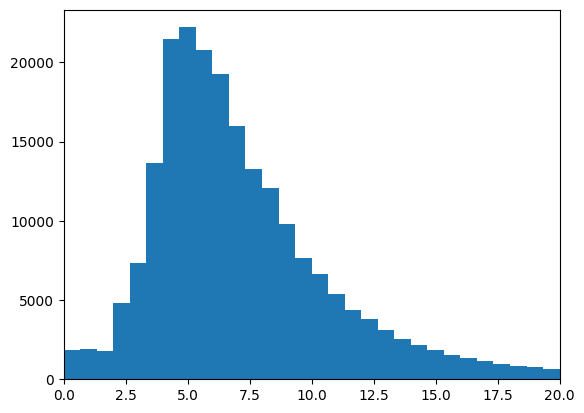

In [83]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [84]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


## Input-Output generator function

In [85]:
# from gwsnr import antenna_response_array, cubic_spline_interpolator2d

# def input_output(idx, params):

#     mass_1 = np.array(params['mass_1'])[idx]
#     mass_2 = np.array(params['mass_2'])[idx]
#     luminosity_distance = np.array(params['luminosity_distance'])[idx]
#     theta_jn = np.array(params['theta_jn'])[idx]
#     psi = np.array(params['psi'])[idx]
#     geocent_time = np.array(params['geocent_time'])[idx]
#     ra = np.array(params['ra'])[idx]
#     dec = np.array(params['dec'])[idx]
    
#     detector_tensor = gwsnr.detector_tensor_list
#     snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
#     ratio_arr = gwsnr.ratio_arr
#     mtot_arr = gwsnr.mtot_arr
    
#     size = len(mass_1)
#     len_ = len(detector_tensor)
#     mtot = mass_1 + mass_2
#     ratio = mass_2 / mass_1
#     # get array of antenna response
#     Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

#     Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
#     eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
#     A1 = Mc ** (5.0 / 6.0)
#     ci_2 = np.cos(theta_jn) ** 2
#     ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
#     size = len(mass_1)
#     snr_half_ = np.zeros((len_,size))
#     d_eff = np.zeros((len_,size))

#     # loop over the detectors
#     for j in range(len_):
#         # loop over the parameter points
#         for i in range(size):
#             snr_half_coeff = snr_halfscaled[j]
#             snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
#             d_eff[j,i] =luminosity_distance[i] / np.sqrt(
#                     Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
#                 )

#     #amp0
#     amp0 =  A1 / d_eff

#     # get spin parameters
#     a_1 = np.array(params['a_1'])[idx]
#     a_2 = np.array(params['a_2'])[idx]
#     tilt_1 = np.array(params['tilt_1'])[idx]
#     tilt_2 = np.array(params['tilt_2'])[idx]
#     # phi_12 = np.array(params['phi_12'])[idx]
#     # phi_jl = np.array(params['phi_jl'])[idx]

#     # effective spin
#     chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


#     # input data
#     # error=2.41%, 3.60%
#     # 4.93%, 3.46%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2]).T

#     # error=2.72%, 3.32%
#     # 4.73%, 3.19%
#     # 3.20%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

#     # error=2.79%, 3.28%
#     # 4.46%, 3.18%
#     # 3.27%
#     XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
#     XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
#     XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

#     # output data
#     # get L1 snr for y train
#     yL1 = params['L1'][idx]
#     yH1 = params['H1'][idx]
#     yV1 = params['V1'][idx]

#     return(XL1, XH1, XV1, yL1, yH1, yV1)

In [86]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T 

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]

    return(XL1, yL1)

In [87]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, yL1 = input_output(idx, unlensed_params)
np.shape(XL1)

(216856, 4)

In [88]:
#concatenate XL1, yL1
data_ = np.concatenate((XL1, yL1[:,None]), axis=1)

## Initial scaling of the input data

### Half-SNR

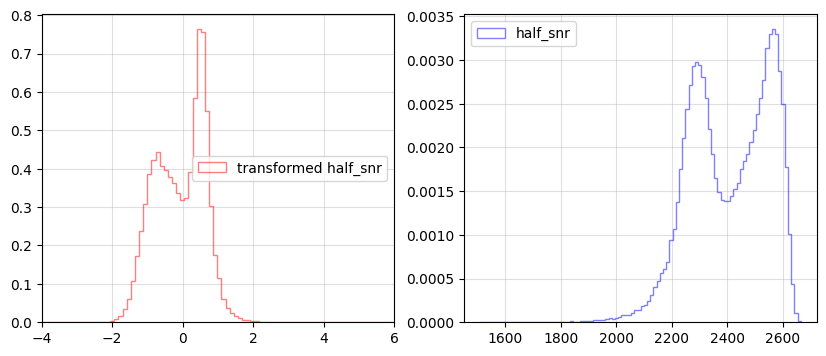

In [89]:
half_snr = data_[:,0]
#len(half_snr)
idx_constrain = (half_snr>1500)&(half_snr<2900)
half_snr_ = half_snr[idx_constrain]
min_ = np.min(half_snr_)
max_ = np.max(half_snr_)
half_snr_ = half_snr
half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
median_ = np.median(half_snr_)
half_snr_ = half_snr_ - median_ # center the data

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(half_snr_, bins=100, alpha=0.5, label='transformed half_snr', color='r', histtype='step', density=True)
ax[0].set_xlim(-4,6)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(half_snr[idx_constrain], bins=100, alpha=0.5, label='half_snr', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()


In [90]:
# this information needs to be save as meta data
print("median: ", median_)
print("min: ", min_)
print("max: ", max_)
meta_dict = dict()
meta_dict["half_snr"] = dict(
    median=median_,
    min=min_,
    max=max_,
)

median:  -1.2184341667802339
min:  1511.7809177041981
max:  2663.6583036223305


In [91]:
half_snr_[:10]

array([ 1.0071306 ,  0.61461626,  0.24742518, -0.25853253, -0.87083919,
       -0.84625726, -0.83859844, -0.61782088,  0.50848616, -0.33308289])

In [92]:
# check for invertability
def half_snr_forward_transform(half_snr, median=-1.2184184161205907, min_data=1511.7809177041981, max_data=2663.6583036223305):
    half_snr_ = scale_to_range(half_snr, min_data, max_data)
    half_snr_ = sine_to_gaussian(half_snr_)- median
    return half_snr_

def half_snr_backward_transform(half_snr_, median=-1.2184184161205907, min_data=1511.7809177041981, max_data=2663.6583036223305):
    half_snr_ = gaussian_to_sine(half_snr_ + median)
    half_snr_ = unscale_to_range(half_snr_, min_data, max_data)
    return half_snr_

half_snr = data_[:,0]
idx_constrain = (half_snr>1500)&(half_snr<2900)
half_snr_ = half_snr[idx_constrain]
print("original: ", half_snr_[:10])
# forward transform
transformed_half_snr = half_snr_forward_transform(half_snr_)
print("\nforward transform: ", transformed_half_snr[:10])
# backward transform
half_snr_ = half_snr_backward_transform(transformed_half_snr)
print("\nbackward transform: ", half_snr_[:10])

original:  [2149.3730033  2260.53064927 2356.17548497 2467.55627893 2564.06986371
 2561.01518413 2560.04993494 2529.40269625 2289.20995844 2481.61429338]

forward transform:  [ 1.00711485  0.61460051  0.24740943 -0.25854828 -0.87085494 -0.84627301
 -0.83861419 -0.61783663  0.50847041 -0.33309864]

backward transform:  [2149.3730033  2260.53064927 2356.17548497 2467.55627893 2564.06986371
 2561.01518413 2560.04993494 2529.40269625 2289.20995844 2481.61429338]


### Amp0

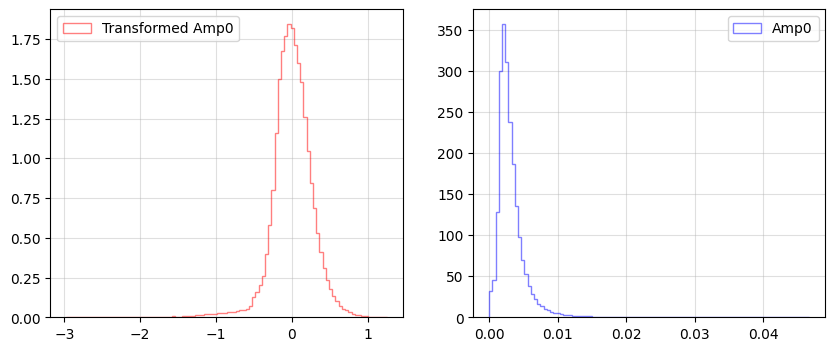

In [93]:
amp0 = data_[:,1]
amp0 = np.log10(amp0)
median_ = np.median(amp0)
amp0 = amp0 - median_

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(amp0, bins=100, alpha=0.5, label='Transformed Amp0', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,1][idx_constrain], bins=100, alpha=0.5, label='Amp0', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [94]:
# this information needs to be save as meta data
print("median: ", median_)
meta_dict["amp0"] = dict(
    median=median_
)

median:  -2.578595991699393


In [95]:
amp0[:10]

array([ 0.23353862,  0.42225332, -0.12290485, -1.07417503,  0.59409067,
       -0.22873773,  0.01017232, -0.02078235, -0.19373893,  0.00995892])

In [96]:
# check for invertability
def amp0_forward_transform(amp0, median=-2.578595991699393):
    amp0_ = np.log10(amp0)
    amp0_ = amp0_ - median
    return amp0_

def amp0_backward_transform(amp0_, median=-2.578595991699393):
    amp0_ = 10**(amp0_ + median)
    return amp0_

amp0 = data_[:,1]
print("original: ", amp0[:10])
# forward transform
transformed_amp0 = amp0_forward_transform(amp0)
print("\nforward transform: ", transformed_amp0[:10])
# backward transform
amp0_ = amp0_backward_transform(transformed_amp0)
print("\nbackward transform: ", amp0_[:10])

original:  [0.00451796 0.00697682 0.00198838 0.00022245 0.01036322 0.00155835
 0.00270132 0.00251548 0.00168914 0.00269999]

forward transform:  [ 0.23353862  0.42225332 -0.12290485 -1.07417503  0.59409067 -0.22873773
  0.01017232 -0.02078235 -0.19373893  0.00995892]

backward transform:  [0.00451796 0.00697682 0.00198838 0.00022245 0.01036322 0.00155835
 0.00270132 0.00251548 0.00168914 0.00269999]


### $\eta$

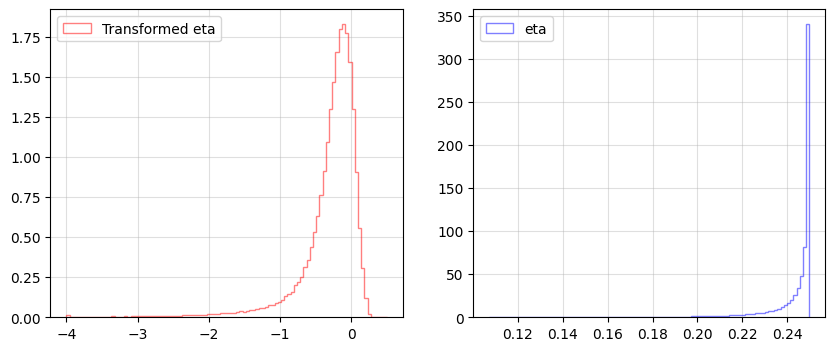

In [97]:
eta = data_[:,2]
# eta = eta[idx_constrain]
min1, max1 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min1, max_data=max1)
eta = sine_to_gaussian(eta)
min2, max2 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min2, max_data=max2)
eta = np.log10(eta)

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(eta, bins=100, alpha=0.5, label='Transformed eta', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,2][idx_constrain], bins=100, alpha=0.5, label='eta', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [98]:
# this information needs to be save as meta data
print("min1: ", min1)
print("max1: ", max1)
print("min2: ", min2)
print("max2: ", max2)
meta_dict["eta"] = dict(
    min1=min1,
    max1=max1,
    min2=min2,
    max2=max2,
)

min1:  0.08741723125122514
max1:  0.24999999999998757
min2:  -5.847172146111127
max2:  5.847172146111127


In [99]:
eta[:10]

array([ 0.1387624 ,  0.04774537, -0.0249495 , -0.52784922, -1.37795423,
       -2.14436912, -0.33228696, -0.60298304, -0.16711581, -0.50020479])

In [100]:
# check for invertability
def eta_forward_transform(eta, min1=0.08741723125122514, max1=0.24999999999998757, min2=-5.847172146111127, max2=5.847172146111127):
    eta_ = scale_to_range(eta, min_data=min1, max_data=max1)
    eta_ = sine_to_gaussian(eta_)
    eta_ = scale_to_range(eta_, min_data=min2, max_data=max2)
    eta_ = np.log10(eta_)
    return eta_

def eta_backward_transform(eta_, min1=0.08741723125122514, max1=0.24999999999998757, min2=-5.847172146111127, max2=5.847172146111127):
    eta_ = 10**(eta_)
    eta_ = unscale_to_range(eta_, min_data=min2, max_data=max2)
    eta_ = gaussian_to_sine(eta_)
    eta_ = unscale_to_range(eta_, min_data=min1, max_data=max1)
    return eta_

eta = data_[:,2]
print("original: ", eta[:10])
# forward transform
transformed_eta = eta_forward_transform(eta)
print("\nforward transform: ", transformed_eta[:10])
# backward transform
eta_ = eta_backward_transform(transformed_eta)
print("\nbackward transform: ", eta_[:10])

original:  [0.19765588 0.22780534 0.23972484 0.24989908 0.24999697 0.24999957
 0.24955021 0.24993689 0.24778509 0.24987842]

forward transform:  [ 0.1387624   0.04774537 -0.0249495  -0.52784922 -1.37795423 -2.14436912
 -0.33228696 -0.60298304 -0.16711581 -0.50020479]

backward transform:  [0.19765588 0.22780534 0.23972484 0.24989908 0.24999697 0.24999957
 0.24955021 0.24993689 0.24778509 0.24987842]


### $\chi_{eff}$

* no transformation needed

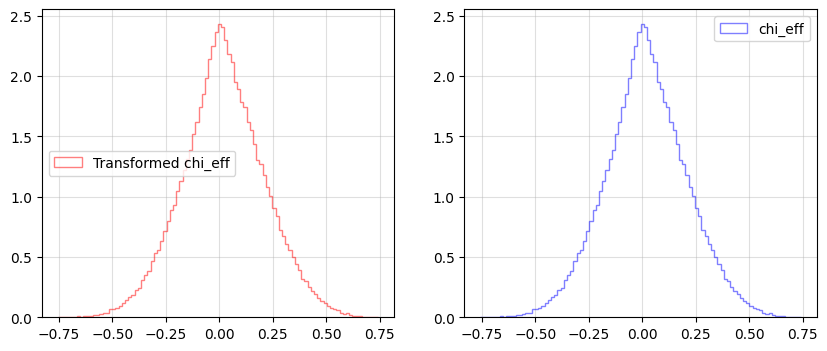

In [101]:
chi_eff = data_[:,3]
# gaussian ppf
# min_ = np.min(chi_eff)
# max_ = np.max(chi_eff)
# chi_eff_ = scale_to_range(chi_eff, min_data=min_, max_data=max_, min_target=0+0.001, max_target=1-0.001)
# chi_eff_ = norm.ppf(chi_eff_)
# chi_eff_ = chi_eff_ - np.median(chi_eff_)
chi_eff_ = chi_eff


# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(chi_eff_, bins=100, alpha=0.5, label='Transformed chi_eff', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,3], bins=100, alpha=0.5, label='chi_eff', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

### $\theta_{jn}$

In [102]:
# theta_jn = data_[:,4]
# theta_jn_ = theta_jn
# # theta_jn_ = sine_to_gaussian(theta_jn_)

# # two plots side by side
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# ax[0].hist(theta_jn_, bins=100, alpha=0.5, label='Transformed theta_jn', color='r', histtype='step', density=True)
# ax[0].legend()
# ax[0].grid(alpha=0.4)
# ax[1].hist(data_[:,4], bins=100, alpha=0.5, label='theta_jn', color='b', histtype='step', density=True)
# ax[1].legend()
# ax[1].grid(alpha=0.4)
# plt.show()


### $\rho_{opt}$

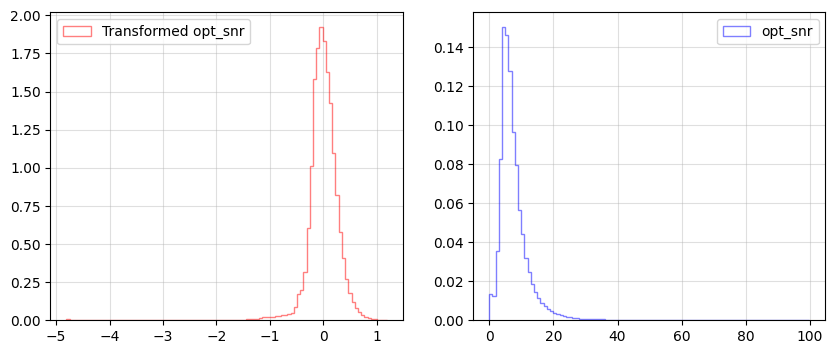

In [103]:
opt_snr = data_[:,4]
opt_snr_ = opt_snr
# change 0 to 0.001
opt_snr_[opt_snr_==0] = 0.0001
opt_snr_ = np.log10(opt_snr)
median_ = np.median(opt_snr_)
opt_snr_ = opt_snr_ - median_

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(opt_snr_, bins=100, alpha=0.5, label='Transformed opt_snr', color='r', histtype='step', density=True)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(data_[:,4], bins=100, alpha=0.5, label='opt_snr', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [104]:
# this information needs to be save as meta data
print("median: ", median_)
meta_dict["opt_snr"] = dict(
    median=median_
)

median:  0.807615261055657


In [105]:
opt_snr_[:10]

array([ 0.15112614,  0.37857675, -0.13656876, -0.97830572,  0.63726913,
       -0.19321124,  0.02414674, -0.00257159, -0.17074212,  0.03505354])

In [106]:
# check for invertability
def opt_snr_forward_transform(opt_snr, median=0.807615261055657):
    opt_snr[opt_snr==0] = 0.0001
    opt_snr_ = np.log10(opt_snr)
    opt_snr_ = opt_snr_ - median
    return opt_snr_

def opt_snr_backward_transform(opt_snr_, median=0.807615261055657):
    opt_snr_ = 10**(opt_snr_ + median)
    opt_snr_[opt_snr_==0.0001] = 0.
    return opt_snr_

opt_snr = data_[:,4]
print("original: ", opt_snr[:10])
# forward transform
transformed_opt_snr = opt_snr_forward_transform(opt_snr)
print("\nforward transform: ", transformed_opt_snr[:10])
# backward transform
opt_snr_ = opt_snr_backward_transform(transformed_opt_snr)
print("\nbackward transform: ", opt_snr_[:10])

original:  [ 9.09371638 15.35295609  4.68863586  0.67500897 27.85379602  4.11532393
  6.7883152   6.38327669  4.33384264  6.96095457]

forward transform:  [ 0.15112614  0.37857675 -0.13656876 -0.97830572  0.63726913 -0.19321124
  0.02414674 -0.00257159 -0.17074212  0.03505354]

backward transform:  [ 9.09371638 15.35295609  4.68863586  0.67500897 27.85379602  4.11532393
  6.7883152   6.38327669  4.33384264  6.96095457]


In [107]:
meta_dict_all = dict(
    L1=dict(
        psd='aLIGO_O4_high_asd.txt',
        meta=meta_dict,
    )
)

In [108]:
# save the meta data json file
import json
with open('meta_data.json', 'w') as f:
    json.dump(meta_dict_all, f)

In [109]:
# call meta data
with open('meta_data.json', 'r') as f:
    meta_dict_all = json.load(f)

meta_dict_all['L1']['meta']

{'half_snr': {'median': -1.2184341667802339,
  'min': 1511.7809177041981,
  'max': 2663.6583036223305},
 'amp0': {'median': -2.578595991699393},
 'eta': {'min1': 0.08741723125122514,
  'max1': 0.24999999999998757,
  'min2': -5.847172146111127,
  'max2': 5.847172146111127},
 'opt_snr': {'median': 0.807615261055657}}

## Scaling the data

In [111]:
# now scale all
data_ = np.concatenate((XL1, yL1[:,None]), axis=1)
data_new = []
# scale half_snr
half_snr = data_[:,0]
half_snr_ = half_snr_forward_transform(half_snr)
data_new.append(half_snr_)
# scale amp0
amp0 = data_[:,1]
amp0_ = amp0_forward_transform(amp0)
data_new.append(amp0_)
# scale eta
eta = data_[:,2]
eta_ = eta_forward_transform(eta)
data_new.append(eta_)
#data_new.append(eta)
# scale chi_eff
chi_eff = data_[:,3]
chi_eff_ = chi_eff
data_new.append(chi_eff_)
# scale opt_snr
opt_snr = data_[:,4]
opt_snr_ = opt_snr_forward_transform(opt_snr)
data_new.append(opt_snr_)

data_new = np.array(data_new).T

In [112]:
XL1 = data_new[:,:-1]
yL1 = data_new[:,-1]

## L1

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [114]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [115]:
np.shape(y_train)

(195170,)

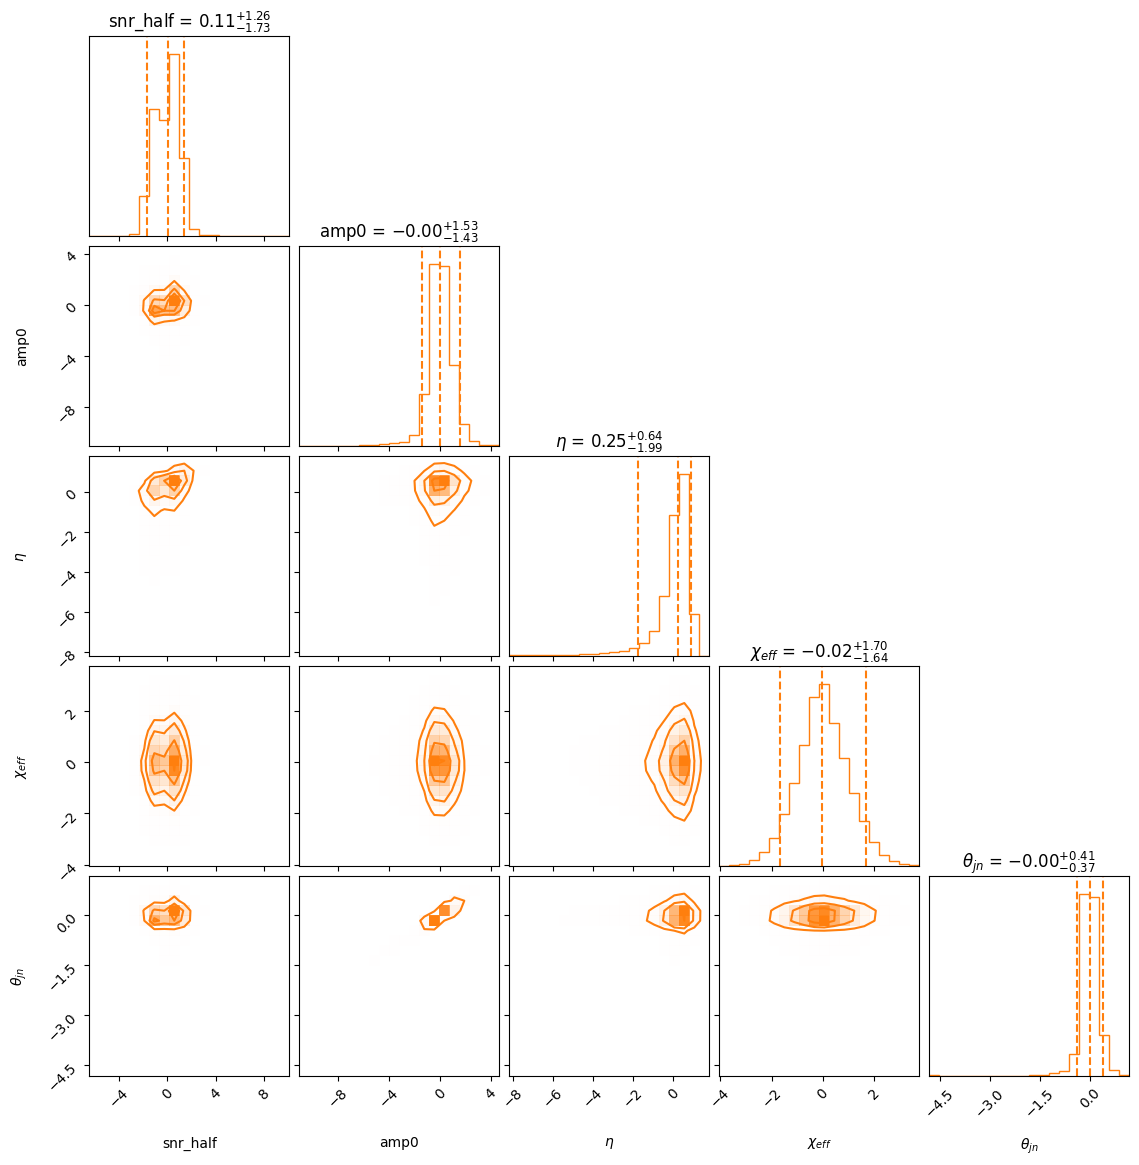

In [116]:
import corner
# plot the corner plot
#concatenate XL1, yL1
data_ = np.concatenate((X_train, y_train[:,None]), axis=1)

labels = [
    r"snr_half",
    r"amp0",
    r"$\eta$",
    r"$\chi_{eff}$",
    r"$\theta_{jn}$",
    r"$\rho_{opt}$",
]
fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})
plt.gcf()
plt.show()

In [117]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [118]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [119]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [120]:
# 3m 29.6s multi-threading
# 3m 46.2s single-threading
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - accuracy: 0.0000e+00 - loss: 0.0445
Epoch 2/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step - accuracy: 0.0000e+00 - loss: 0.0101
Epoch 3/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 399us/step - accuracy: 0.0000e+00 - loss: 0.0109
Epoch 4/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 413us/step - accuracy: 0.0000e+00 - loss: 0.0098
Epoch 5/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 388us/step - accuracy: 0.0000e+00 - loss: 0.0103
Epoch 6/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 407us/step - accuracy: 0.0000e+00 - loss: 0.0096
Epoch 7/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step - accuracy: 0.0000e+00 - loss: 0.0082
Epoch 8/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 414us/step - accuracy: 0.0000e+00 - loss: 0.0089
Epoch 9/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 391us/step - accuracy: 0.0000e+00 - loss: 0.0086
Epoch 10/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - accuracy: 0.0000e+00 - loss: 0.0078
Epoch 11/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 379us/step - a

In [122]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
[[-0.2794041  -0.08673295]
 [ 0.25462955  0.26762535]
 [ 0.27322191  0.27769824]
 [ 0.05934584  0.06509688]
 [ 0.08960068  0.10002176]
 [ 0.21099442  0.21059157]
 [-0.14690378 -0.18923224]
 [-0.06001428 -0.0494453 ]
 [-0.00859964 -0.00183892]
 [ 0.11501533  0.11814947]
 [-0.02003914 -0.02058595]
 [-0.28070268 -0.29705034]
 [ 0.12576443  0.08440811]
 [-0.02767444 -0.02271469]
 [ 0.22080857  0.22266572]]


In [123]:
y_pred = ann.predict(X_test)
# unscale
y_pred_ = opt_snr_backward_transform(y_pred)

y_test_ = opt_snr_backward_transform(y_test)

print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test_.reshape(len(y_test_),1)),1)[10:25])

  1/678 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
[[ 3.37451363  5.25874745]
 [11.54103851 11.8916088 ]
 [12.04584408 12.17064237]
 [ 7.36141205  7.45954154]
 [ 7.89252472  8.0841994 ]
 [10.43781948 10.42813957]
 [ 4.57837677  4.15320169]
 [ 5.59243631  5.73020241]
 [ 6.29528856  6.39405464]
 [ 8.36817265  8.42878024]
 [ 6.1316328   6.12391727]
 [ 3.3644383   3.24014855]
 [ 8.57787514  7.79872073]
 [ 6.02477503  6.09397363]
 [10.67637444 10.72212782]]


In [124]:
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.85%


21686
7924


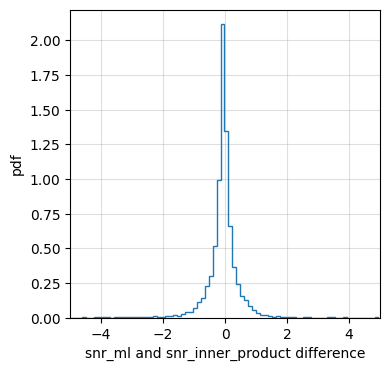

In [125]:
import matplotlib.pyplot as plt

y_pred_ = y_pred_.copy().flatten()
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [128]:
# Save the model to a file
ann.save('ann_modelL1.h5')

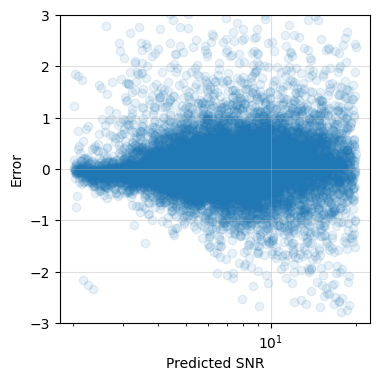

In [127]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = opt_snr_backward_transform(y_pred).flatten()
y_test_ = opt_snr_backward_transform(y_test).flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test_[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## H1

In [155]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['H1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['H1']))

216908
216853


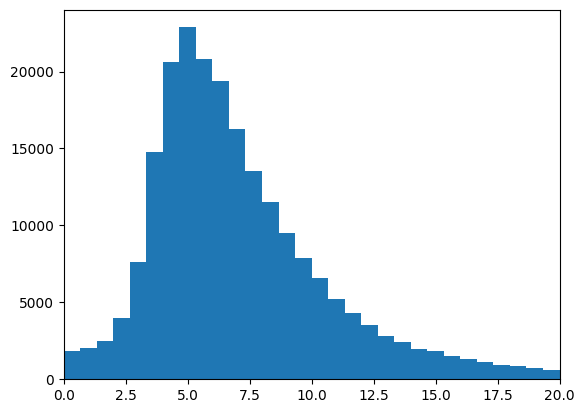

In [156]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['H1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [157]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['H1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['H1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [158]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XH1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T 

    # output data
    # get H1 snr for y train
    yH1 = params['H1'][idx]

    return(XH1, yH1)

In [159]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XH1, yH1 = input_output(idx, unlensed_params)
np.shape(XH1)

(216853, 4)

In [160]:
#concatenate XH1, yH1
data_ = np.concatenate((XH1, yH1[:,None]), axis=1)

In [162]:
# half_snr = data_[:,0]
# #len(half_snr)
# idx_constrain = (half_snr>1500)&(half_snr<2900)
# half_snr_ = half_snr[idx_constrain]
# min_ = np.min(half_snr_)
# max_ = np.max(half_snr_)
# half_snr_ = half_snr
# half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
# half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
# median_ = np.median(half_snr_)
# half_snr_ = half_snr_ - median_ # center the data

# # two plots side by side
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# ax[0].hist(half_snr_, bins=100, alpha=0.5, label='transformed half_snr', color='r', histtype='step', density=True)
# ax[0].set_xlim(-4,6)
# ax[0].legend()
# ax[0].grid(alpha=0.4)
# ax[1].hist(half_snr[idx_constrain], bins=100, alpha=0.5, label='half_snr', color='b', histtype='step', density=True)
# ax[1].legend()
# ax[1].grid(alpha=0.4)
# plt.show()

In [113]:
half_snr = data_[:,0]
#len(half_snr)
idx_constrain = (half_snr>1500)&(half_snr<2900)
half_snr_ = half_snr[idx_constrain]
min_ = np.min(half_snr_)
max_ = np.max(half_snr_)
half_snr_ = half_snr
half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
median_ = np.median(half_snr_)
half_snr_ = half_snr_ - median_ # center the data

# this information needs to be save as meta data
print("median: ", median_)
print("min: ", min_)
print("max: ", max_)
meta_dict = dict()
meta_dict["half_snr"] = dict(
    median=median_,
    min=min_,
    max=max_,
)


median:  -1.218393181351966
min:  1511.780917705039
max:  2663.658303622331


In [114]:
amp0 = data_[:,1]
amp0 = np.log10(amp0)
median_ = np.median(amp0)
amp0 = amp0 - median_

# this information needs to be save as meta data
print("median: ", median_)
meta_dict["amp0"] = dict(
    median=median_
)

median:  -2.581974587801979


In [115]:
eta = data_[:,2]
# eta = eta[idx_constrain]
min1, max1 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min1, max_data=max1)
eta = sine_to_gaussian(eta)
min2, max2 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min2, max_data=max2)
eta = np.log10(eta)

# this information needs to be save as meta data
print("min1: ", min1)
print("max1: ", max1)
print("min2: ", min2)
print("max2: ", max2)
meta_dict["eta"] = dict(
    min1=min1,
    max1=max1,
    min2=min2,
    max2=max2,
)

min1:  0.08741723125122514
max1:  0.24999999999998757
min2:  -5.847172146111127
max2:  5.847172146111127


In [116]:
# chi_eff = data_[:,3]
# chi_eff_ = chi_eff

In [117]:
opt_snr = data_[:,4]
opt_snr_ = opt_snr
# change 0 to 0.001
opt_snr_[opt_snr_==0] = 0.0001
opt_snr_ = np.log10(opt_snr)
median_ = np.median(opt_snr_)
opt_snr_ = opt_snr_ - median_

# this information needs to be save as meta data
print("median: ", median_)
meta_dict["opt_snr"] = dict(
    median=median_
)

median:  0.8047504994568596


In [118]:
# call meta data
with open('meta_data.json', 'r') as f:
    meta_dict_all = json.load(f)

meta_dict_all['H1'] = dict(
    psd='aLIGO_O4_high_asd.txt',
    meta=meta_dict,
)

# save the meta data json file
import json
with open('meta_data.json', 'w') as f:
    json.dump(meta_dict_all, f)


### Scaling H1 data

In [119]:
# now scale all
data_ = np.concatenate((XH1, yH1[:,None]), axis=1)
data_new = []
# scale half_snr
half_snr = data_[:,0]
half_snr_ = half_snr_forward_transform(half_snr, median=meta_dict["half_snr"]["median"], min_data=meta_dict["half_snr"]["min"], max_data=meta_dict["half_snr"]["max"])
data_new.append(half_snr_)
# scale amp0
amp0 = data_[:,1]
amp0_ = amp0_forward_transform(amp0, median=meta_dict["amp0"]["median"])
data_new.append(amp0_)
# scale eta
eta = data_[:,2]
eta_ = eta_forward_transform(eta, min1=meta_dict["eta"]["min1"], max1=meta_dict["eta"]["max1"], min2=meta_dict["eta"]["min2"], max2=meta_dict["eta"]["max2"])
data_new.append(eta_)
# scale chi_eff
chi_eff = data_[:,3]
chi_eff_ = chi_eff
data_new.append(chi_eff_)
# scale opt_snr
opt_snr = data_[:,4]
opt_snr_ = opt_snr_forward_transform(opt_snr, median=meta_dict["opt_snr"]["median"])
data_new.append(opt_snr_)

data_new = np.array(data_new).T

In [120]:
XH1 = data_new[:,:-1]
yH1 = data_new[:,-1]

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [122]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [123]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [124]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


6099/6099 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - accuracy: 1.5515e-06 - loss: 0.0171
Epoch 2/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step - accuracy: 3.8425e-06 - loss: 0.0116
Epoch 3/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step - accuracy: 5.7623e-07 - loss: 0.0111
Epoch 4/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step - accuracy: 1.9020e-06 - loss: 0.0122
Epoch 5/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step - accuracy: 1.3582e-05 - loss: 0.0127
Epoch 6/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step - accuracy: 8.2560e-06 - loss: 0.0102
Epoch 7/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step - accuracy: 4.7846e-06 - loss: 0.0112
Epoch 8/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 350us/step - accuracy: 1.3534e-05 - loss: 0.0084
Epoch 9/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step - accuracy: 9.3327e-07 - loss: 0.0104
Epoch 10/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - accuracy: 2.3191e-07 - loss: 0.0094
Epoch 11/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 350us/step - a

In [125]:
y_pred = ann.predict(X_test)
# unscale
y_pred_ = opt_snr_backward_transform(y_pred)

y_test_ = opt_snr_backward_transform(y_test)

print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test_.reshape(len(y_test_),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
[[ 4.93750572  5.41457771]
 [ 2.37340879  2.12583011]
 [ 2.23842597  2.21275954]
 [ 6.00873804  6.03087489]
 [ 5.78859043  4.44814687]
 [ 4.46278143  4.35382469]
 [ 4.92228556  4.85331401]
 [ 7.09275675  7.91256443]
 [ 3.90535045  3.76819554]
 [ 7.61069155  7.28045097]
 [12.7333889  12.86153873]
 [ 9.46737194 10.20850193]
 [ 4.68208075  4.62185803]
 [ 7.73064804  8.27628981]
 [ 5.5758152   5.58918799]]


In [126]:
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.84%


In [127]:
# Save the model to a file
ann.save('ann_modelH1.h5')

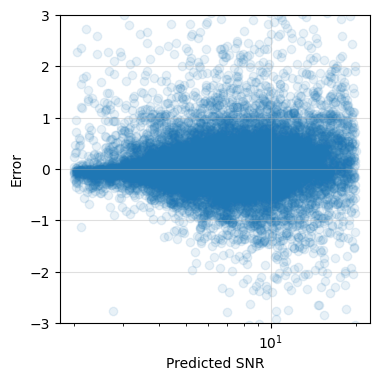

In [129]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = opt_snr_backward_transform(y_pred).flatten()
y_test_ = opt_snr_backward_transform(y_test).flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test_[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrH1_param4.png")
plt.show()

## V1

In [200]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['V1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['V1']))

216908
216879


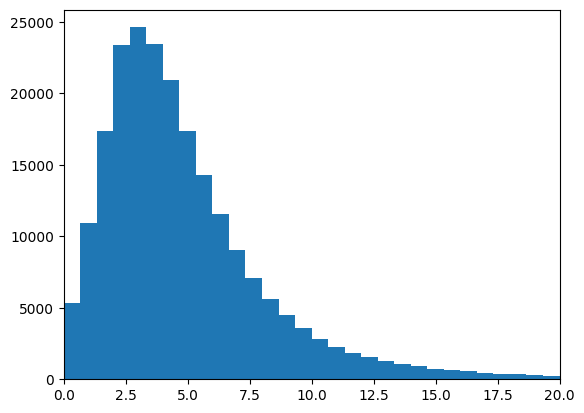

In [201]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['V1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [202]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['V1']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


In [203]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XV1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T 

    # output data
    # get V1 snr for y train
    yV1 = params['V1'][idx]

    return(XV1, yV1)

In [204]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XV1, yV1 = input_output(idx, unlensed_params)
np.shape(XV1)

(216879, 4)

In [205]:
#concatenate XV1, yV1
data_ = np.concatenate((XV1, yV1[:,None]), axis=1)
np.shape(data_)

(216879, 5)

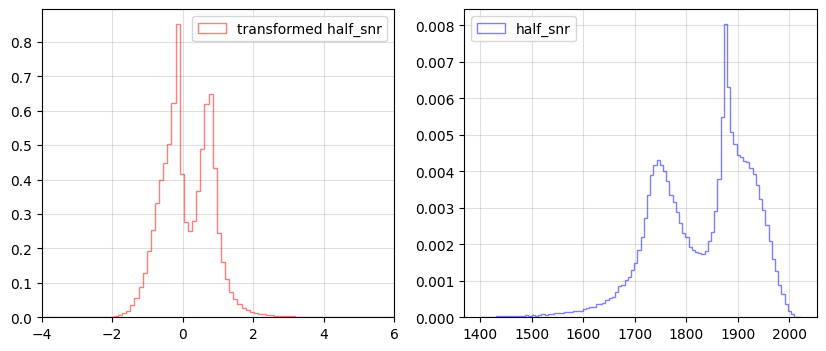

In [169]:
half_snr = data_[:,0]
#len(half_snr)
idx_constrain = (half_snr>1400)&(half_snr<2200)
half_snr_ = half_snr[idx_constrain]
min_ = np.min(half_snr_)
max_ = np.max(half_snr_)
half_snr_ = half_snr
half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
median_ = np.median(half_snr_)
half_snr_ = half_snr_ - median_ # center the data

# two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(half_snr_, bins=100, alpha=0.5, label='transformed half_snr', color='r', histtype='step', density=True)
ax[0].set_xlim(-4,6)
ax[0].legend()
ax[0].grid(alpha=0.4)
ax[1].hist(half_snr[idx_constrain], bins=100, alpha=0.5, label='half_snr', color='b', histtype='step', density=True)
ax[1].legend()
ax[1].grid(alpha=0.4)
plt.show()

In [170]:
half_snr = data_[:,0]
#len(half_snr)
idx_constrain = (half_snr>1500)&(half_snr<2200)
half_snr_ = half_snr[idx_constrain]
min_ = np.min(half_snr_)
max_ = np.max(half_snr_)
half_snr_ = half_snr
half_snr_ = scale_to_range(half_snr_, min_data=min_, max_data=max_) # scale to range 0 to pi
half_snr_ = sine_to_gaussian(half_snr_) # transform from sine like function to gaussian. This avoids the boundary effect
median_ = np.median(half_snr_)
half_snr_ = half_snr_ - median_ # center the data

# this information needs to be save as meta data
print("median: ", median_)
print("min: ", min_)
print("max: ", max_)
meta_dict = dict()
meta_dict["half_snr"] = dict(
    median=median_,
    min=min_,
    max=max_,
)

median:  -0.7397310323246209
min:  1500.1280513991383
max:  2022.44436009841


In [171]:
amp0 = data_[:,1]
amp0 = np.log10(amp0)
median_ = np.median(amp0)
amp0 = amp0 - median_

# this information needs to be save as meta data
print("median: ", median_)
meta_dict["amp0"] = dict(
    median=median_
)

median:  -2.6577558010959197


In [172]:
eta = data_[:,2]
# eta = eta[idx_constrain]
min1, max1 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min1, max_data=max1)
eta = sine_to_gaussian(eta)
min2, max2 = np.min(eta), np.max(eta)
eta = scale_to_range(eta, min_data=min2, max_data=max2)
eta = np.log10(eta)

# this information needs to be save as meta data
print("min1: ", min1)
print("max1: ", max1)
print("min2: ", min2)
print("max2: ", max2)
meta_dict["eta"] = dict(
    min1=min1,
    max1=max1,
    min2=min2,
    max2=max2,
)

min1:  0.08741723125122514
max1:  0.24999999999998757
min2:  -5.847172146111127
max2:  5.847172146111127


In [173]:
opt_snr = data_[:,4]
opt_snr_ = opt_snr
# change 0 to 0.001
opt_snr_[opt_snr_==0] = 0.0001
opt_snr_ = np.log10(opt_snr)
median_ = np.median(opt_snr_)
opt_snr_ = opt_snr_ - median_

# this information needs to be save as meta data
print("median: ", median_)
meta_dict["opt_snr"] = dict(
    median=median_
)

median:  0.6130341196856053


In [174]:
# call meta data
with open('meta_data.json', 'r') as f:
    meta_dict_all = json.load(f)

meta_dict_all['V1'] = dict(
    psd='AdV_asd.txt',
    meta=meta_dict,
)

### Scaling V1 data

In [175]:
# now scale all
data_ = np.concatenate((XV1, yV1[:,None]), axis=1)
data_new = []
# scale half_snr
half_snr = data_[:,0]
half_snr_ = half_snr_forward_transform(half_snr, median=meta_dict["half_snr"]["median"], min_data=meta_dict["half_snr"]["min"], max_data=meta_dict["half_snr"]["max"])
data_new.append(half_snr_)
# scale amp0
amp0 = data_[:,1]
amp0_ = amp0_forward_transform(amp0, median=meta_dict["amp0"]["median"])
data_new.append(amp0_)
# scale eta
eta = data_[:,2]
eta_ = eta_forward_transform(eta, min1=meta_dict["eta"]["min1"], max1=meta_dict["eta"]["max1"], min2=meta_dict["eta"]["min2"], max2=meta_dict["eta"]["max2"])
data_new.append(eta_)
# scale chi_eff
chi_eff = data_[:,3]
chi_eff_ = chi_eff
data_new.append(chi_eff_)
# scale opt_snr
opt_snr = data_[:,4]
opt_snr_ = opt_snr_forward_transform(opt_snr, median=meta_dict["opt_snr"]["median"])
data_new.append(opt_snr_)

data_new = np.array(data_new).T

In [176]:
XV1 = data_new[:,:-1]
yV1 = data_new[:,-1]

In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [179]:
# import corner
# # plot the corner plot
# #concatenate XL1, yL1
# data_ = np.concatenate((X_train, y_train[:,None]), axis=1)

# labels = [
#     r"snr_half",
#     r"amp0",
#     r"$\eta$",
#     r"$\chi_{eff}$",
#     r"$\theta_{jn}$",
#     r"$\rho_{opt}$",
# ]
# fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})
# plt.gcf()
# plt.show()

In [180]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [181]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [182]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 375us/step - accuracy: 1.0652e-05 - loss: 0.0207
Epoch 2/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step - accuracy: 1.6415e-06 - loss: 0.0122
Epoch 3/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 388us/step - accuracy: 4.6082e-06 - loss: 0.0137
Epoch 4/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 382us/step - accuracy: 6.5556e-07 - loss: 0.0115
Epoch 5/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 387us/step - accuracy: 1.3180e-05 - loss: 0.0131
Epoch 6/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - accuracy: 1.3888e-06 - loss: 0.0138
Epoch 7/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step - accuracy: 3.5777e-06 - loss: 0.0119
Epoch 8/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step - accuracy: 2.1404e-06 - loss: 0.0135
Epoch 9/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 371us/step - accuracy: 1.6046e-06 - loss: 0.0104
Epoch 10/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - accuracy: 4.6936e-06 - loss: 0.0118
Epoch 11/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 402us/step - a

In [183]:
y_pred = ann.predict(X_test)
# unscale
y_pred_ = opt_snr_backward_transform(y_pred)

y_test_ = opt_snr_backward_transform(y_test)

print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test_.reshape(len(y_test_),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
[[11.04966545 11.12358188]
 [ 5.27481604  5.72487196]
 [ 2.99800324  2.71181973]
 [ 6.32041931  6.61793475]
 [12.66610336 11.74998786]
 [ 2.17775059  2.32940946]
 [ 7.59477615  7.72085554]
 [ 5.27900505  5.06841765]
 [ 7.21917152  6.70100611]
 [ 0.74697596  0.72106688]
 [ 7.50779009  8.80779227]
 [ 1.83117986  1.78747764]
 [10.00652981  9.41917391]
 [ 5.02247715  5.03624638]
 [ 5.39025545  5.42504884]]


In [184]:
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.58%


In [185]:
# Save the model to a file
ann.save('ann_modelV1.h5')

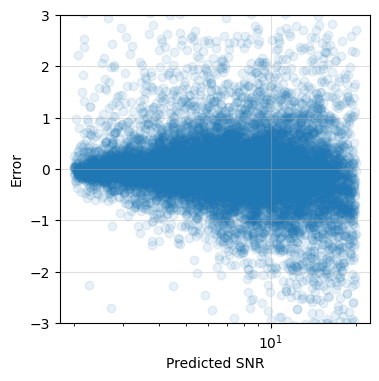

In [187]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = opt_snr_backward_transform(y_pred).flatten()
y_test_ = opt_snr_backward_transform(y_test).flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test_[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrv1_param4.png")
plt.show()

## Load all models and test them

In [129]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the meta data
import json
with open('meta_data.json', 'r') as f:
    meta_dict_all = json.load(f)

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

## BBH

In [130]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpam

In [131]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(np.array(params['L1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y, np.array(params['L1'])[idx])

In [132]:
# generating new data
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

In [76]:
## Uncomment to generate new data if not already generated
size_ = 50000
ler.batch_size = 25000
ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=False);

unlensed params will be store in ./ler_data/unlensed_param_testing.json
chosen batch size = 25000 with total size = 50000
There will be 2 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 23616/23616 [00:46<00:00, 503.90it/s]


Batch no. 2
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 23561/23561 [00:44<00:00, 534.76it/s]


saving all unlensed_params in ./ler_data/unlensed_param_testing.json 


In [133]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [135]:
X_, Y_, snrL1 = input_output_net(np.arange(len(unlensed_params['L1'])), unlensed_params)
np.shape(X_[0])

(50000, 4)

In [136]:
# L1
# initial scaling
data_ = X_[0]
data_new = []
# scale half_snr
half_snr = data_[:,0]
half_snr_ = half_snr_forward_transform(half_snr, median=meta_dict_all["L1"]["meta"]["half_snr"]["median"], min_data=meta_dict_all["L1"]["meta"]["half_snr"]["min"], max_data=meta_dict_all["L1"]["meta"]["half_snr"]["max"])
data_new.append(half_snr_)
# scale amp0
amp0 = data_[:,1]
amp0_ = amp0_forward_transform(amp0, median=meta_dict_all["L1"]["meta"]["amp0"]["median"])
data_new.append(amp0_)
# scale eta
eta = data_[:,2]
eta_ = eta_forward_transform(eta, min1=meta_dict_all["L1"]["meta"]["eta"]["min1"], max1=meta_dict_all["L1"]["meta"]["eta"]["max1"], min2=meta_dict_all["L1"]["meta"]["eta"]["min2"], max2=meta_dict_all["L1"]["meta"]["eta"]["max2"])
data_new.append(eta_)
#data_new.append(eta)

# scale chi_eff
chi_eff = data_[:,3]
chi_eff_ = chi_eff
data_new.append(chi_eff_)
data_new = np.array(data_new).T
# scaler transform
x = scalerL1.transform(data_new)

In [137]:
# np.round(snrL1,8)==9.41905155
# 6.61016938 6.35281549
np.where(np.round(snrL1,8)==6.35281549)[0]

array([41804])

In [138]:
idxidx = 41804
x[:,0][idxidx], x[:,1][idxidx], x[:,2][idxidx], x[:,3][idxidx], unlensed_params['a_1'][idxidx], unlensed_params['a_2'][idxidx]

(2.2434567925791518,
 -1.809375563059939,
 1.019260844433419,
 0.23893059821386875,
 0.5861459904631146,
 0.44975027363156717)

In [139]:
y_pred = modelL1.predict(x).flatten()
# unscale
y_pred_ = opt_snr_backward_transform(y_pred, median=meta_dict_all["L1"]["meta"]["opt_snr"]["median"])

y_test_ = snrL1
idx = (y_test_>6) & (y_test_<10)
y_pred_ = y_pred_[idx]
y_test_ = y_test_[idx]

print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test_.reshape(len(y_test_),1)),1)[:])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
[[ 9.71031189  8.37264323]
 [ 6.03754044  6.08253142]
 [ 7.49718046  8.10900647]
 [ 6.34524155  6.53987562]
 [ 7.47166967  7.64317072]
 [ 6.39371252  6.45474988]
 [ 7.53889418  7.42176855]
 [ 6.2379446   6.43454205]
 [ 6.41785717  6.84108021]
 [ 6.03482008  6.45232595]
 [ 6.01050377  6.04834994]
 [ 8.03925419  8.06745302]
 [ 6.09574842  6.34537863]
 [ 7.21620703  7.3953399 ]
 [ 6.28511381  6.14583937]
 [ 7.25382328  7.36668992]
 [ 8.65211391  8.83326747]
 [ 4.39754677  6.58250399]
 [ 6.84432268  6.88068083]
 [ 5.94723034  6.00676755]
 [ 9.08208752  9.29325364]
 [ 8.45346642  7.13618657]
 [ 5.97489834  6.11026731]
 [ 6.32830191  6.45960054]
 [ 6.21559334  6.02239107]
 [ 8.60723114  7.90036234]
 [ 7.40919065  7.49219498]
 [ 8.58251381  8.48841842]
 [ 6.26399231  6.80922024]
 [ 6.82029915  7.14241753]
 [ 8.17007446  8.65667959]
 [ 8.12458134  8.19300083]
 [ 8.86757469  8.72468378]
 [ 9.45532322  8.88535465]
 [10.04418564  9.36444172]
 [ 9.45302

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
50000
121
[4.397547 1.854281]
[6.58250399 6.35281549]


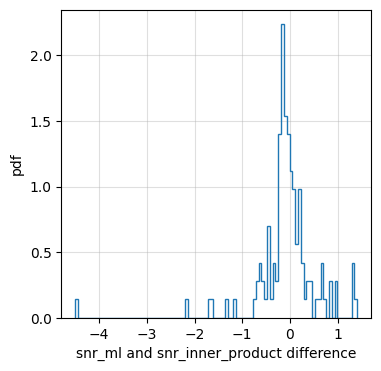

In [140]:
import matplotlib.pyplot as plt

y_pred = modelL1.predict(x).flatten()
# unscale
y_pred_ = opt_snr_backward_transform(y_pred, median=meta_dict_all["L1"]["meta"]["opt_snr"]["median"])
y_test_ = snrL1
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
# idx = idx & (x[:,2]>-3)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
idx_ = abs(hist_)>2.0
print(y_pred_[idx][idx_])
print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step
50000
121
[2.217718]
[6.35281549]


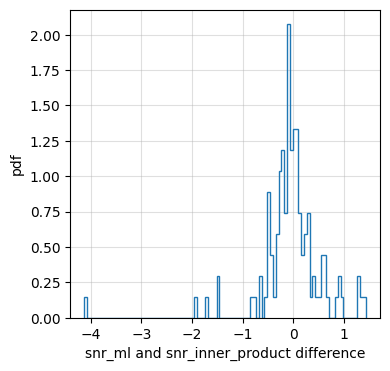

In [80]:
import matplotlib.pyplot as plt

y_pred = modelL1.predict(x).flatten()
# unscale
y_pred_ = opt_snr_backward_transform(y_pred, median=meta_dict_all["L1"]["meta"]["opt_snr"]["median"])
y_test_ = snrL1
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
# idx = idx & (x[:,2]>-3)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
idx_ = abs(hist_)>2.0
print(y_pred_[idx][idx_])
print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step
50000
118
[]
[]


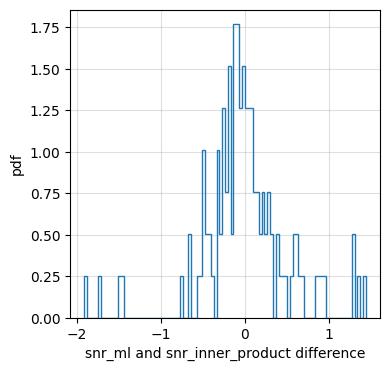

In [79]:
import matplotlib.pyplot as plt

y_pred = modelL1.predict(x).flatten()
# unscale
y_pred_ = opt_snr_backward_transform(y_pred, median=meta_dict_all["L1"]["meta"]["opt_snr"]["median"])
y_test_ = snrL1
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
idx = idx & (x[:,2]>-3)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
idx_ = abs(hist_)>2.0
print(y_pred_[idx][idx_])
print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

array([0.31607117, 1.03870124, 0.30919956, ..., 0.95377807, 1.12901431,
       0.52875218])

In [209]:
def input_output_netANN(x_array):
    # L1
    # initial scaling
    data_ = x_array[0]
    data_new = []
    # scale half_snr
    half_snr = data_[:,0]
    half_snr_ = half_snr_forward_transform(half_snr, median=meta_dict_all["L1"]["meta"]["half_snr"]["median"], min_data=meta_dict_all["L1"]["meta"]["half_snr"]["min"], max_data=meta_dict_all["L1"]["meta"]["half_snr"]["max"])
    data_new.append(half_snr_)
    # scale amp0
    amp0 = data_[:,1]
    amp0_ = amp0_forward_transform(amp0, median=meta_dict_all["L1"]["meta"]["amp0"]["median"])
    data_new.append(amp0_)
    # scale eta
    eta = data_[:,2]
    eta_ = eta_forward_transform(eta, min1=meta_dict_all["L1"]["meta"]["eta"]["min1"], max1=meta_dict_all["L1"]["meta"]["eta"]["max1"], min2=meta_dict_all["L1"]["meta"]["eta"]["min2"], max2=meta_dict_all["L1"]["meta"]["eta"]["max2"])
    data_new.append(eta_)
    # scale chi_eff
    chi_eff = data_[:,3]
    chi_eff_ = chi_eff
    data_new.append(chi_eff_)
    data_new = np.array(data_new).T
    # scaler transform
    x = scalerL1.transform(data_new)
    # predict the scaled opt snr
    yL1 = modelL1.predict(x)
    # scale back to original
    yL1 = opt_snr_backward_transform(yL1, median=meta_dict_all["L1"]["meta"]["opt_snr"]["median"])


    # H1
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])




    
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [210]:
meta_dict_all["L1"]["meta"]["opt_snr"]

{'median': 0.807615261055657}

In [211]:
_, snrANN =input_output_netANN(X_)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


IndexError: boolean index did not match indexed array along dimension 0; dimension is 25000 but corresponding boolean dimension is 216879

In [530]:
y_pred = snrANN.flatten()
y_test = Y_

In [531]:
len(y_test)

25000

In [532]:
len(y_pred)

25000

In [563]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<12)
popt, pcov = curve_fit(func, y_pred[idx], y_pred[idx]-y_test[idx])
print(popt)

[-0.07411881  0.87044046]


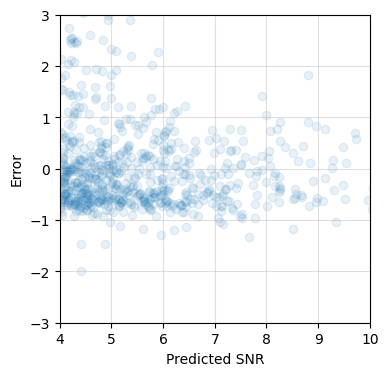

In [564]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
y_pred_ = y_pred_-(popt[0]*y_pred+popt[1])
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
#plt.scatter(y_test[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

25000
777


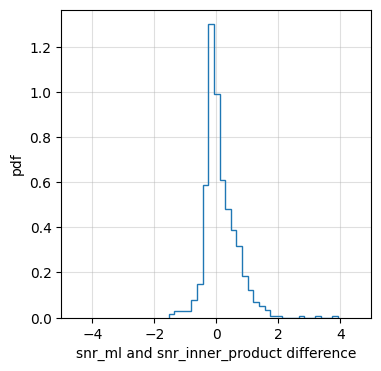

In [565]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [562]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1120%


In [566]:
len1 = len(y_pred)
len2 = np.sum(((y_pred-(popt[0]*y_pred+popt[1]))>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1040%


In [567]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.0)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24869    18]
 [   10   103]]


0.99888

In [568]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.2)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24875    12]
 [   14    99]]


0.99888

In [569]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_pred<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1)-0.2, y_test.reshape(len(y_test),1)),1)[idx][:10])

[[6.98862362 7.3244188 ]
 [8.07498264 8.73664642]
 [8.58827877 9.05212486]
 [6.86917257 7.01070622]
 [7.88767624 8.33806557]
 [7.8469162  8.45750222]
 [8.56952381 8.94146165]
 [8.12943077 7.33984516]
 [7.83821392 7.59029936]
 [6.58561087 7.04858059]]


## BNS

In [540]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [541]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


  1%|▌                                                          | 527/50000 [00:10<17:00, 48.47it/s]


KeyboardInterrupt: 

In [ ]:
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined